**32 x 32 Pixel Art Generator**

Yo this is the colab for https://github.com/zzbuzzard/pixartdiffusion, you can use it to generate some mediocre 32x32 pixel art. It's trained on sprites from [here](https://play.google.com/store/apps/details?id=com.zts.ageofstrategy) and [here](https://play.google.com/store/apps/details?id=com.zts.ageoffantasy).

To use it, set the parameters in the second box, then press Runtime -> Run All. After that, you can rerun just the second box.

In [1]:
#@markdown #Setup - run once
#@markdown Clones repo + loads CLIP model
!git clone https://github.com/zzbuzzard/pixartdiffusion
!pip install ./pixartdiffusion
!pip install git+https://github.com/openai/CLIP.git

from google.colab import output
from pixartdiffusion import util, model, sample, parameters
import clip
from matplotlib import image
import torch
import os

os.makedirs("outputs/", exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load UNET model
model = model.UNet().to(device)
epoch = util.load_model(model, "pixartdiffusion/models/AOS_AOF.pt")
print("Loaded AOS_AOF model from epoch", epoch)

CLIP_MODEL = 'ViT-B/32' #@param ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14']

# Load CLIP
print("Loading CLIP model...")
clip_model, clip_preprocess = clip.load(CLIP_MODEL, device=device) # TODO: Support other models
# Art is scaled up by this amount before being fed to CLIP
assert clip_model.visual.input_resolution%32==0, "Input resolution must be divisible by 32... try another model."
clip_res_mul = clip_model.visual.input_resolution // 32

OUTPUT_NUM = 1

output.clear()

!nvidia-smi

print("Done")

Mon Apr  4 03:06:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    59W / 149W |    889MiB / 11441MiB |     27%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Generating 6 * 4 * 4 = 96 samples...


  5%|▍         | 24/490 [00:01<00:31, 14.77it/s]

ITERATION 465


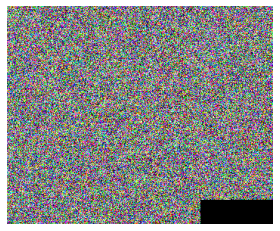

 15%|█▍        | 73/490 [00:05<00:27, 15.14it/s]

ITERATION 416


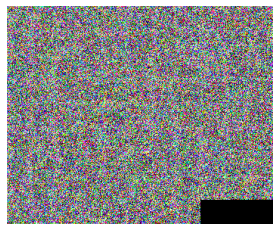

 25%|██▍       | 122/490 [00:08<00:24, 15.11it/s]

ITERATION 367


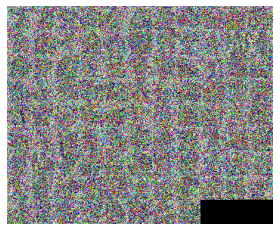

 35%|███▍      | 171/490 [00:12<00:21, 15.00it/s]

ITERATION 318


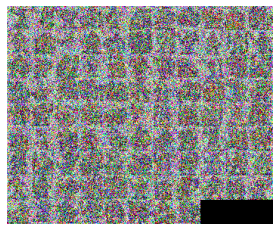

 45%|████▍     | 220/490 [00:15<00:17, 15.12it/s]

ITERATION 269


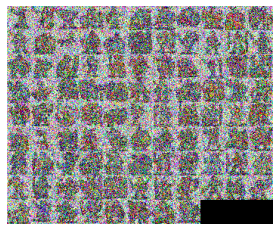

 55%|█████▍    | 269/490 [00:19<00:14, 15.11it/s]

ITERATION 220


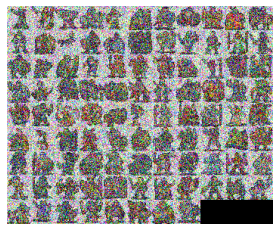

 65%|██████▍   | 318/490 [00:22<00:11, 15.02it/s]

ITERATION 171


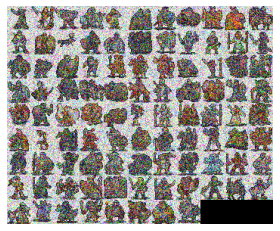

 75%|███████▍  | 367/490 [00:26<00:08, 15.02it/s]

ITERATION 122


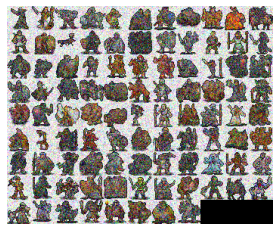

 85%|████████▍ | 416/490 [00:29<00:04, 15.07it/s]

ITERATION 73


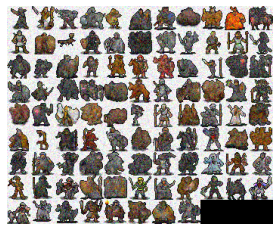

 95%|█████████▍| 465/490 [00:33<00:01, 14.98it/s]

ITERATION 24


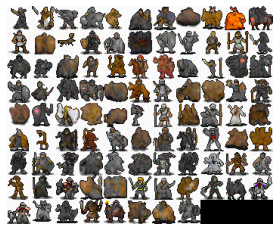

100%|██████████| 490/490 [00:35<00:00, 13.89it/s]


All samples (before CLIP re-ranking):


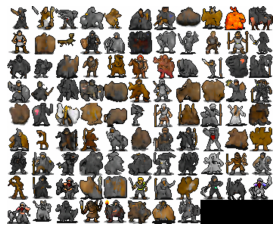

Your samples, sir:


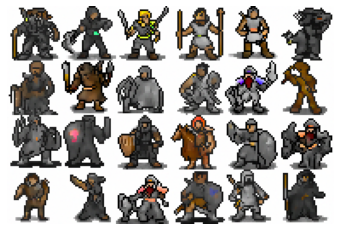

Output saved to outputs/output1.png


In [2]:
#@markdown #Parameters

#@markdown \
#@markdown ### Main Parameters

#@markdown A spritesheet of given width and height (in terms of samples) will be generated. Note that this requires `sheet_width*sheet_height` total samples.
sheet_width =  6#@param{type:"integer"}
sheet_height =  4#@param{type:"integer"}

#@markdown The noise multiplier determines how much extra noise is added on during sampling. Higher values lead to more chaotic samples, lower values lead to featureless blobs. I recommend 6-10.
noise_mul =  7.5#@param{type:"number"}

#@markdown How many times to display the output during generation.
display_count =  10#@param{type:"integer"}

#@markdown \
#@markdown ### CLIP Selection - I recommend u use this
#@markdown Generates lots of samples then selects the ones that match `selection_prompt` best using CLIP. If you are using CLIP Guidance as well, it would make sense to use the same prompt.
#@markdown Just using a generic prompt like 'pixel art' works ok!
selection_prompt = "cool colourful pixel art character #pixelart" #@param{type:"string"}

#@markdown How many samples are computed per output sample. For example, if `sheet_width=sheet_height=10` and `generation_multiplier=5`, then 500 samples will be computed, and the output will be the top 100 according to CLIP. Leave at 1 for no CLIP selection.
generation_multiplier =  4#@param{type:"integer"}

#@markdown \
#@markdown ### CLIP Guidance
#@markdown **CLIP Guidance is very, very slow, and doesn't work that well.** If you're on a K80 (as I usually am), it'll take ~2min per sample (depending on shiftn). I haven't had much chance to experiment with it, but the choice of CLIP model also makes a big difference - ViT-B/32 and ViT-B/16 seem to work best (though I haven't tried them all).
use_clip_guidance = False #@param{type:"boolean"}
prompt = "a green octopus #pixelart" #@param{type:"string"}
#@markdown Number of times to shift the output and feed to CLIP. Higher values will take longer to compute, but in theory will be more true to the prompt.
shiftn =  8#@param{type:"integer"}

#@markdown Multiplier for CLIP guidance. Higher values should 'look more like the prompt'. I recommend 50-150.
classifier_mul = 100 #@param{type:"integer"}

print(f"Generating {sheet_width} * {sheet_height} * {generation_multiplier} = {sheet_width * sheet_height * generation_multiplier} samples...")

#@markdown Should be between 0 and 1. 0 Leads to a very noise-free output, 1 leads to a noisier but closer
classifier_dropoff = 0.25 #@param{type:"number"}


### Do the run:

# Classifier mul should be ~50 to 200
def getσ_classifier(t):
    L = torch.tensor(classifier_dropoff, dtype=torch.float)
    H = torch.tensor(1, dtype=torch.float)

    return classifier_mul * ((H - L) * t/parameters.STEPS + L).float()


with torch.no_grad():
    if use_clip_guidance:
        tokenized_text = clip.tokenize([prompt]).to(device)

        func = sample.clip_grad_func(clip_model, tokenized_text, num_shifts=shiftn, shift_range=clip_res_mul*2)
        xs = sample.sample(model, sheet_width * sheet_height * generation_multiplier, display_count=display_count, noise_mul=noise_mul, classifier_mul_func=getσ_classifier, classifier_func=func)
    else:
        xs = sample.sample(model, sheet_width * sheet_height * generation_multiplier, display_count=display_count, noise_mul=noise_mul)

    # CLIP Re-rank
    if generation_multiplier != 1:
        top_n = sheet_width * sheet_height
        tokenized_text = clip.tokenize([selection_prompt]).to(device)
        unfiltered_samples = xs
        xs = sample.CLIP_rerank(clip_model, xs, tokenized_text)[:top_n]

        print("All samples (before CLIP re-ranking):")
        all_sheet = util.to_drawable(unfiltered_samples, scale=4)
        util.draw_im(all_sheet)

        del unfiltered_samples

    sheet = util.to_drawable(xs, fix_width = sheet_width)
    print("Your samples, sir:")
    util.draw_im(sheet)

    save_path = f"outputs/output{OUTPUT_NUM}.png"
    image.imsave(save_path, sheet)
    print("Output saved to",save_path)
    OUTPUT_NUM += 1

del xs
del sheet
del tokenized_text